In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [106]:
dataset_url = "https://raw.githubusercontent.com/syaiful919/datasets/master/szeged_weather/weatherHistory.csv"

note: data diperoleh dari https://www.kaggle.com/budincsevity/szeged-weather?select=weatherHistory.csv

In [107]:
df = pd.read_csv(dataset_url)

In [108]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [109]:
df.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

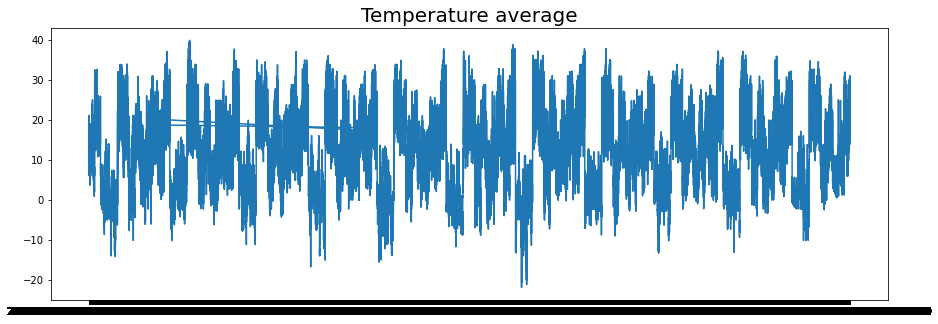

In [112]:
dates = df['Formatted Date'].values
temp  = df['Temperature (C)'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [114]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [115]:
from sklearn.model_selection import train_test_split
dates_train, dates_test, label_train, label_test = train_test_split(dates, temp, test_size=0.2)

In [116]:
data_train = windowed_dataset(label_train, window_size=60, batch_size=100, shuffle_buffer=1000)
data_test = windowed_dataset(label_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [117]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [118]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [119]:
class stopCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\n MAE < 10 %!")
      self.model.stop_training = False
    if(logs.get('val_mae')<5):
      print("\n MAE val < 5 %!")
      self.model.stop_training = True
callbacks = stopCallback()

In [120]:
history = model.fit(data_train,  validation_data=(data_test), epochs=30, callbacks=[callbacks], verbose=2)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


 MAE < 10 %!
772/772 - 77s - loss: 8.9587 - mae: 9.4481 - val_loss: 7.3789 - val_mae: 7.8657
Epoch 2/30

 MAE < 10 %!
772/772 - 84s - loss: 7.4271 - mae: 7.9158 - val_loss: 7.3781 - val_mae: 7.8649
Epoch 3/30

 MAE < 10 %!
772/772 - 85s - loss: 7.4250 - mae: 7.9135 - val_loss: 7.3740 - val_mae: 7.8609
Epoch 4/30

 MAE < 10 %!
772/772 - 85s - loss: 7.4169 - mae: 7.9050 - val_loss: 7.3602 - val_mae: 7.8474
Epoch 5/30

 MAE < 10 %!
772/772 - 84s - loss: 7.3958 - mae: 7.8836 - val_loss: 7.3439 -

In [121]:
import matplotlib.pyplot as plt

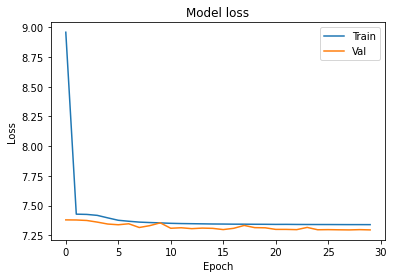

In [122]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

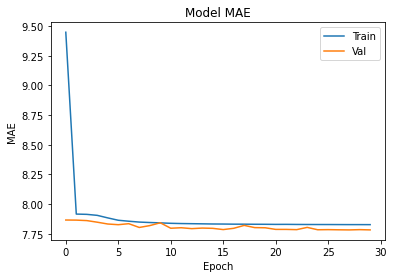

In [123]:
fig, ax = plt.subplots()
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()